In [2]:
#!pip install scikit-learn
#!pip install tensorflow
#!pip install scikit-image
#!pip install seaborn
#!pip install keras_tuner

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import ListedColormap

In [5]:
from PIL import Image

## Setting Working Directory

In [6]:
#current working directory
cur_wd = os.getcwd()
print(cur_wd)


/work/MLDL_Exam/Project


In [7]:
#our images are stored in two seperate folders:
os.listdir(os.path.join(cur_wd, 'archive'))

['.DS_Store', 'train', 'test', 'augmented_train']

In [8]:
#inside each folder of images are further two subfolders dividing the pictures
os.listdir(os.path.join(cur_wd, 'archive', 'test'))

['Benign', '.DS_Store', 'Malignant']

In [9]:
# Define the paths to your training and testing directories
train_dir = './archive/train/'
test_dir = './archive/test/'

In [10]:
#Values
IMG_HEIGHT = 224
IMG_WIDTH = 224
COLOR_CHANNELS = 3

## Loading the Data

In [11]:
from tqdm import tqdm
import numpy as np

def load_images(directory, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    datagen = ImageDataGenerator(rescale=1./255) # rescaling pixels between 0-1
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=32,
        color_mode='rgb',  # Specifies images are to be loaded in RGB mode
        class_mode='binary',  #binary classification
        shuffle=False 
    )
    
    num_images = generator.samples
    data = np.zeros((num_images, target_size[0], target_size[1], 3))  # Keeping the images in 3D
    labels = np.zeros((num_images,))
    i = 0
    
    for x_batch, y_batch in generator:
        batch_size = x_batch.shape[0]
        for j in range(batch_size):
            # Store each image as a 3D array
            data[i] = x_batch[j]
            labels[i] = y_batch[j]
            i += 1
        if i >= num_images:
            break
    
    return data, labels


In [12]:
#Loading the images
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11879, 224, 224, 3)
(11879,)
(2000, 224, 224, 3)
(2000,)


In [14]:
def check_images(directory):
    """
    A function that checks that our pictures are the same size and same file format
    """
    first_file_type = None
    image_sizes = set()

    #we want to iterate through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        try:
            with Image.open(file_path) as img:
                if first_file_type is None:
                    first_file_type = img.format
                elif first_file_type != img.format:
                    print(f"Mixed file types found. {img.format} differs from {first_file_type}")

            image_sizes.add(img.size)

        except IOError:
            print(f"file is not an image or can not be opened {filename}")

    print("Unique image sizes", image_sizes, " file type: ", first_file_type)

In [15]:
check_images('archive/train/Benign')
check_images('archive/train/Malignant')
check_images('archive/test/Benign')
check_images('archive/test/Malignant')

Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG


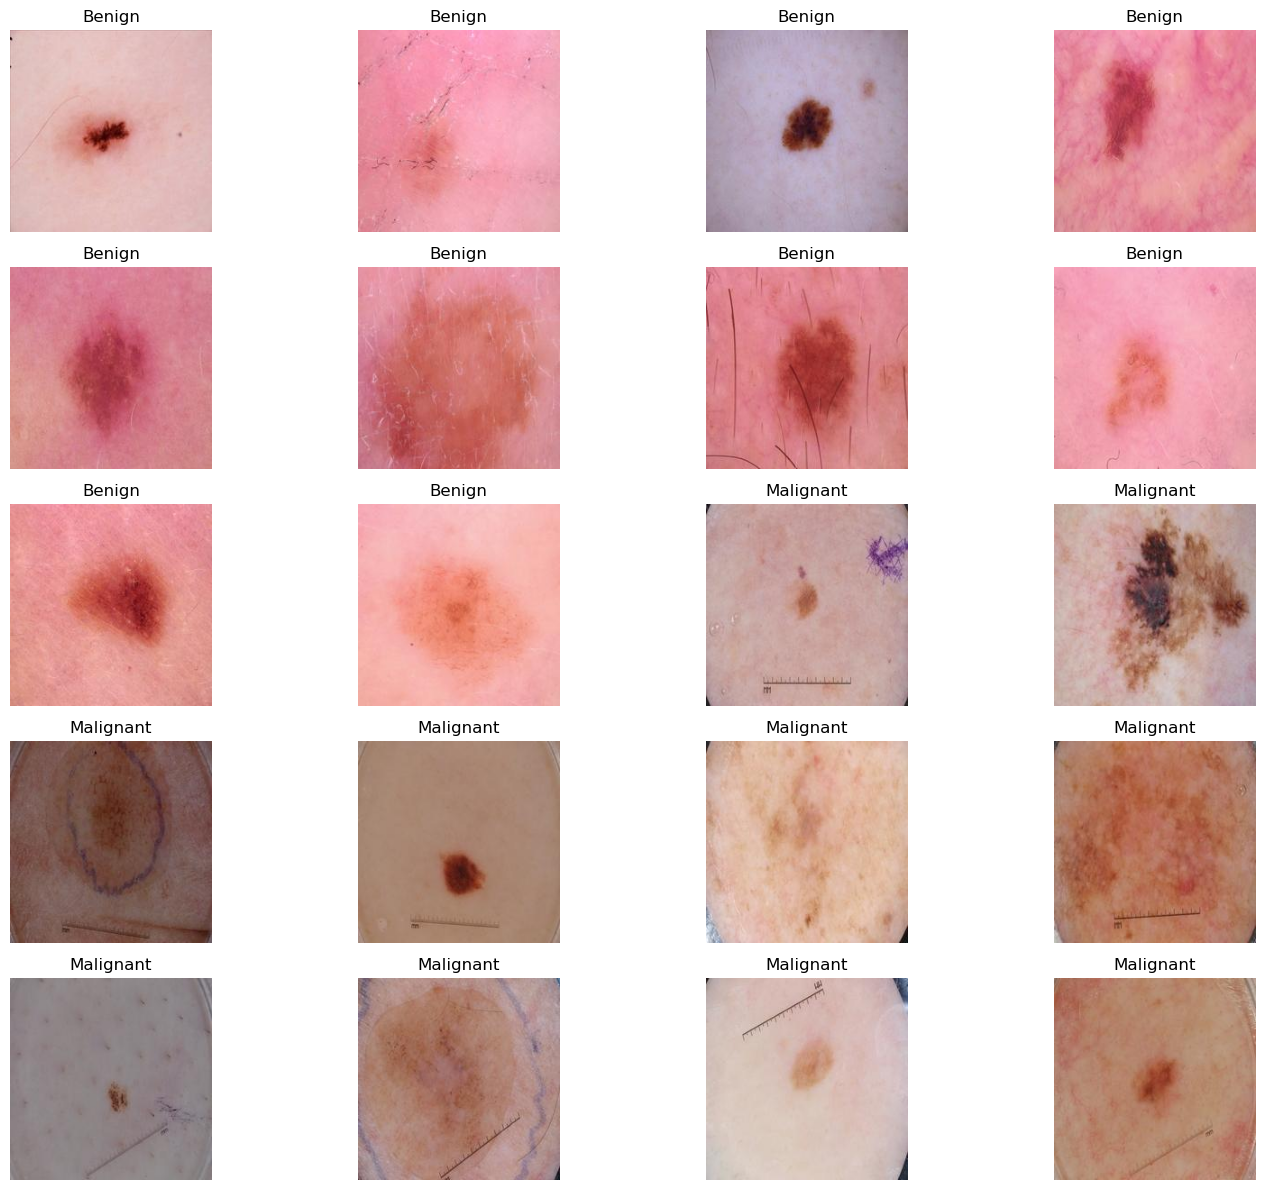

In [16]:
# Selecting 10 benign (first 10) and 10 malignant (from the rest)
benign_images = X_train[:10]  # First 10 benign images
malignant_images = X_train[-10:]  # Last 10 malignant images

# Combining selected images
selected_images = np.vstack([benign_images, malignant_images])

# Create labels corresponding to the selected images
labels = ['Benign']*10 + ['Malignant']*10  

# Plotting
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])  
    ax.set_title(labels[i])  # Adding the label as title to each subplot
    ax.axis('off')  # Turn off axis numbering
plt.tight_layout()
plt.show()


In [17]:
def balance(y, train_test):
    """
    A function that checks the balance of our labels in the training and test dataset
    """
    benign_count = np.count_nonzero(y == 0)
    malignant_count = np.count_nonzero(y == 1)

    cat = ['Benign', 'Malignant']
    counts = [benign_count, malignant_count]
    total = sum(counts)

    plt.figure(figsize = (8, 5))
    bars = plt.bar(cat, counts, color = ['green', 'red'])
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title(f'Distribution of Benign and Malignant Images in {train_test}')

    #adding pct to bars:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval/total: .2%}',
            va = 'bottom',
            ha = 'center')

    plt.show()

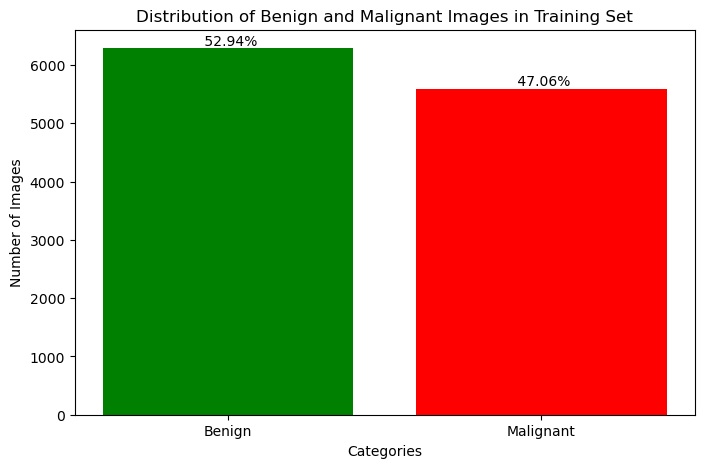

In [18]:
balance(y_train, "Training Set")

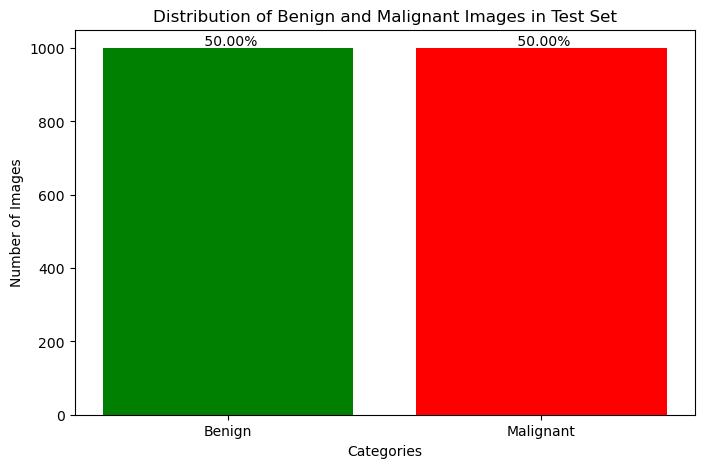

In [19]:
balance(y_test, "Test Set")

## Augmenting our Training Data

In [ ]:
# Using ImageDataGenerator to augment our dataset
train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

# Create directory structure for the augmented images
augmented_train_dir = './archive/augmented_train/'
#subfolders
class_names = ['Benign', 'Malignant']
for cls in class_names:
    os.makedirs(os.path.join(augmented_train_dir, cls), exist_ok=True)

def augment_images(class_name, num_samples):
    #original images to be augmented
    source_dir = os.path.join(train_dir, class_name)
    #where the augmented images are to be stored
    target_dir = os.path.join(augmented_train_dir, class_name)
    
    # generator for the images using our ImageDataGenerator instance
    generator = train_datagen.flow_from_directory(
        train_dir,
        classes=[class_name],
        target_size=(224, 224),  # Adjust size to your requirement
        batch_size=32,
        class_mode='binary',  # Adjust based on your use case
        save_to_dir=target_dir,
        save_prefix='aug',
        save_format='jpg'
    )
    
    # Generate augmented images
    for i in range(num_samples):
        next(generator)

# Number of samples to augment
# notice batchi size of 32 in function
num_samples = 90  # 90 * 32 = 2880 augmented images of both classes

# Augment images for each class
for class_name in class_names:
    augment_images(class_name, num_samples)

In [20]:
augmented_train_dir = './archive/augmented_train/'  
#loading in the augmented images
X_train_aug, y_train_aug = load_images(augmented_train_dir)

Found 5760 images belonging to 2 classes.


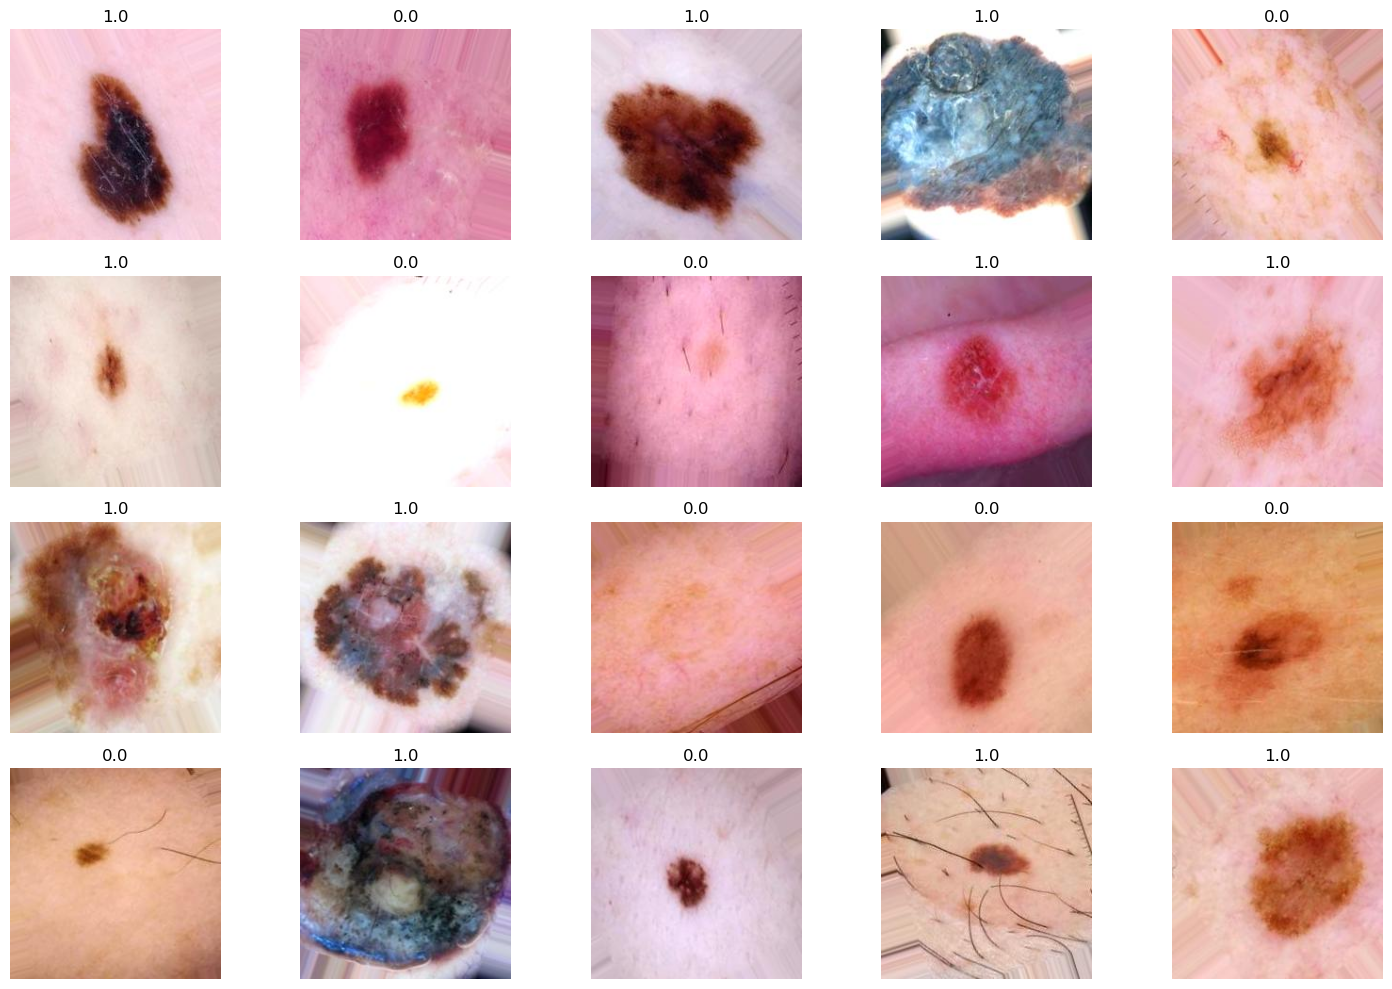

In [21]:
#selecting random images for plotting
indices = np.arange(len(X_train_aug))
np.random.shuffle(indices)

# Plotting the images in a 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

for ax, idx in zip(axes, indices[:20]):  # Display 20 images
    ax.imshow(X_train_aug[idx])  
    ax.set_title(y_train_aug[idx])
    ax.axis('off')

# Turn off axes for any unused subplot areas if there are less than 20 images
for ax in axes[len(indices[:20]):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
#merging original images with augmented images
X_train = np.vstack((X_train, X_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

In [23]:
#ensuring that it worked
X_train.shape[0]

17639

In [24]:
#our data is loaded in one subfolder at a time
"""

our data is loaded in one subfolder at a time
thus, the first x images in our training and test set are of the classe benign and the remaining y malignant
we need to shuffle our data
"""
np.random.seed(64)
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)

X_train = X_train[indices_train]
y_train = y_train[indices_train]

np.random.seed(42)
indices_test = np.arange(X_test.shape[0])
np.random.shuffle(indices_test)

X_test = X_test[indices_test]
y_test = y_test[indices_test]

## PCA

In [25]:
from sklearn.decomposition import PCA

data, labels = load_images(train_dir)
data_flat = data.reshape(data.shape[0],-1)

# Apply PCA
pca = PCA(n_components=0.95, random_state = 64)
principal_components = pca.fit_transform(data_flat)

# Explained variance can help determine the number of components to retain
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Found 11879 images belonging to 2 classes.
Explained variance ratio: 0.9500694951940353


In [26]:
reconstructed_images = pca.inverse_transform(principal_components)

In [27]:
print("Shape of principal components:", principal_components.shape)
print("Shape of reconstructed images:", reconstructed_images.shape)

Shape of principal components: (11879, 67)
Shape of reconstructed images: (11879, 150528)


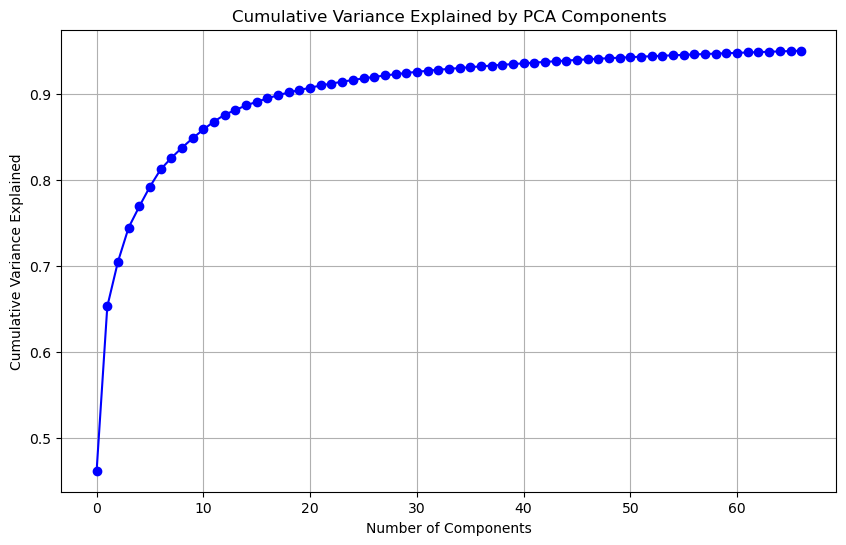

In [28]:
# Plotting
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


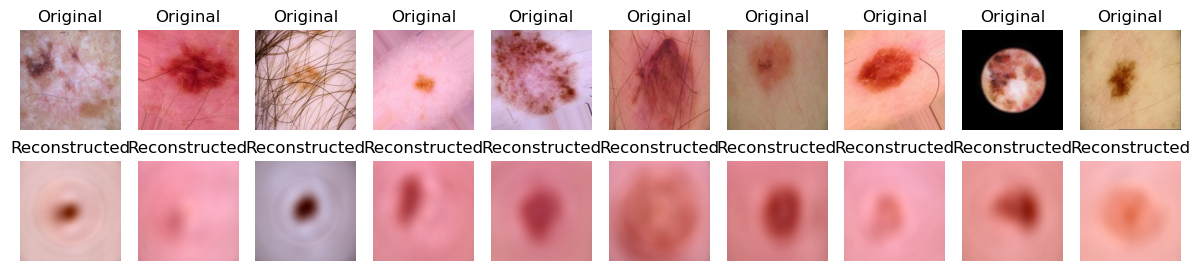

In [32]:
# Reshape the inverse-transformed data (reconstructed images) back to its original dimensions
reconstructed_images_reshaped = reconstructed_images.reshape(-1, IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)

# Number of images to display
num_images_to_display = 10
##
# Plotting
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 3))  # Adjusting size for better view

for i in range(num_images_to_display):
    # Display original images
    ax = axes[0, i]  # First row for original images
    ax.imshow(X_train[i]) 
    ax.set_title("Original")
    ax.axis('off')  # Turn off axis numbering
    
    # Display reconstructed images
    ax = axes[1, i]  # Second row for reconstructed images
    ax.imshow(reconstructed_images_reshaped[i])
    ax.set_title("Reconstructed")
    ax.axis('off')

plt.subplots_adjust(wspace=0.15, hspace=0.3)  # Adjusting spacing to minimize gaps
plt.show()


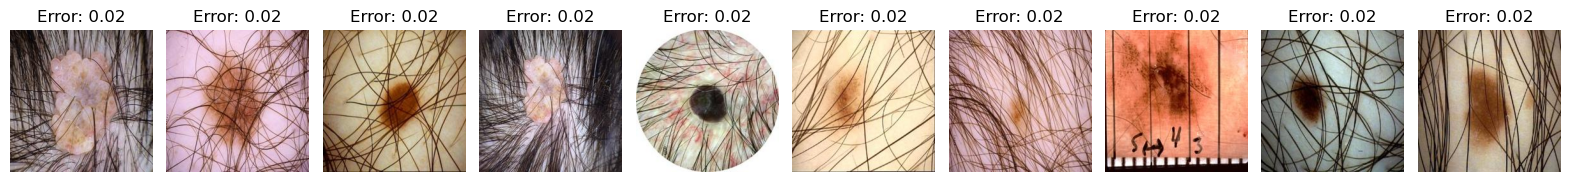

In [34]:
from sklearn.metrics import mean_squared_error

def plot_high_error_images(original_data, reconstructed_data, target_size=(IMG_HEIGHT, IMG_WIDTH), num_images=10):
    # Calculate reconstruction errors for each image
    errors = np.array([mean_squared_error(original.flatten(), reconstructed.flatten())
                       for original, reconstructed in zip(original_data, reconstructed_data)])
    
    # Find the indices of the images with the highest reconstruction errors
    high_error_indices = np.argsort(errors)[-num_images:]
    
    # Plotting
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, ax in enumerate(axes):
        # Reshape the image from (150528,) to (224, 224, 3) before plotting
        image_data = original_data[high_error_indices[i]].reshape(target_size[0], target_size[1], 3)
        ax.imshow(image_data)
        ax.set_title(f'Error: {errors[high_error_indices[i]]:.2f}')
        ax.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

    return high_error_indices, errors[high_error_indices]

# Example usage:
# Assuming `data` and `reconstructed_data` are your original and PCA-reconstructed datasets, respectively
high_error_indices, high_errors = plot_high_error_images(data, reconstructed_images_reshaped, num_images=10)


## Random Forest

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=300, random_state=42, verbose = 1) 
rf.fit(X_train_flat, y_train)

# Predict on the testing set
y_pred = rf.predict(X_test_flat)

# Print out the accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.2min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 20.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


Accuracy: 0.9435
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1000
         1.0       0.93      0.96      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



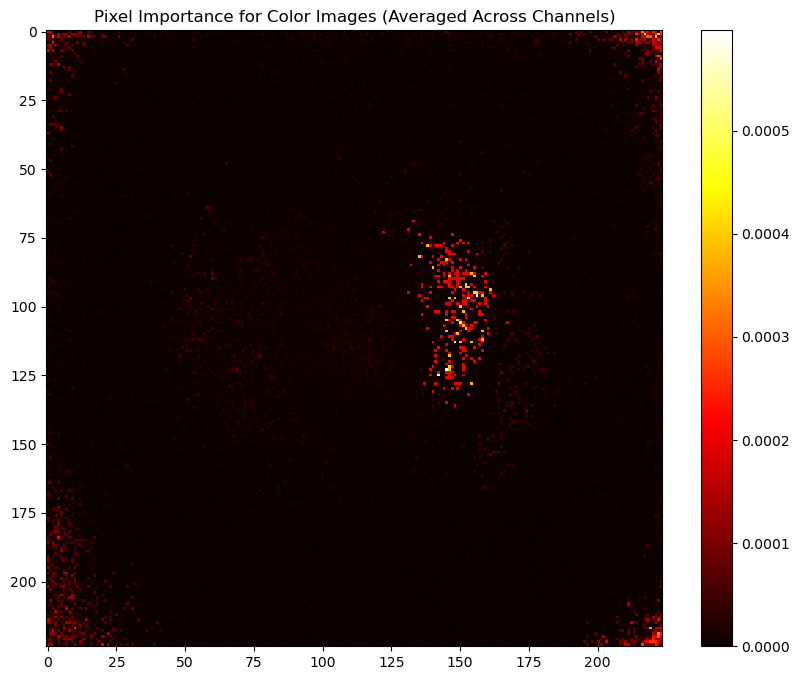

In [36]:
# Reshape the importances back into the original image dimensions with three channels
importances_reshaped = importances.reshape(data.shape[1], data.shape[2], data.shape[3])

# averaging across all 3 color channels for plotting
importances_grayscale = np.mean(importances_reshaped, axis=2)

# Plotting the pixel importance
plt.figure(figsize=(10, 8)) #sh
plt.imshow(importances_grayscale, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Pixel Importance for Color Images (Averaged Across Channels)')
plt.show()

## CNN

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#specifying where to log info about the training
log_dir = "logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Setup ModelCheckpoint to save the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    'MLDL_Exam/Data/best_model.keras',  # Path where the model is saved
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Only save the best model
    save_weights_only=False,  # Save the entire model
    mode='max',  # Save the model with max monitored value
    verbose=1  # Print out messages when saving the model
)

# Setup EarlyStopping to stop training when the validation accuracy stops improving
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    mode='max',
    verbose=1
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

#setting up our grid search space

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)))

    # Tuning the number of convolutional layers
    num_layers = hp.Int('num_conv_layers', 3, 5)

    # Starting with a base number of filters
    initial_filters = hp.Int('initial_filters', min_value=32, max_value=64, step=16)
    increase_factor = hp.Choice('increase_factor', [1.0, 2.0, 3.0])  # More granular control over increase

    filters = initial_filters  # Initialize filters to the initial value
    for i in range(num_layers):
        model.add(keras.layers.Conv2D(
            filters=filters,
            kernel_size=hp.Choice(f'kernel_size_{i}', [3, 5]),
            activation='relu',
            padding='same'
        ))
         # Incrementally increase the number of filters based on the layer depth
        # Update filters for the next layer if not the last layer
        if i < num_layers - 1:
            filters = int(filters * increase_factor)
        if hp.Choice(f'pooling_{i}', ['max', 'avg']) == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=2))
        else:
            model.add(keras.layers.AveragePooling2D(pool_size=2))

    model.add(keras.layers.Flatten())

    # Tuning the number of units in the dense layer and amount of dense layers
    for j in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{j}', min_value=50, max_value=300, step=50),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{j}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Single output neuron

    # Compiling the model and tuning the learning rate for Adam
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Setting up the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=8, 
    executions_per_trial=2,
    directory='MLDL_Exam/Data',  # Specifying the directory where the tuning information will be stored
    project_name='keras_tuner_cnn'
)

# Start the search for the best hyperparameter configuration
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[tensorboard_callback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Number of Convolutional Layers: {best_hps.get('num_conv_layers')}
- Filters per Convolutional Layer: {[best_hps.get(f'filters_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Kernel Sizes: {[best_hps.get(f'kernel_size_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Pooling Types: {[best_hps.get(f'pooling_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Dense Layer Units: {best_hps.get('units')}
- Dropout Rate: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# When training the final model
model.fit(
    X_train, y_train,
    epochs=10, 
    validation_split=0.2,
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
)

In [37]:
import json

##Loading in our log data to find the best model composition of hyperparemeters
# Path to the Keras Tuner directory
tuner_dir = '/work/MLDL_Exam/Project/MLDL_Exam/Data/keras_tuner_cnn'

# Function to load trial details
def load_trial_data(trial_name):
    trial_path = os.path.join(tuner_dir, trial_name, 'trial.json')
    with open(trial_path, 'r') as file:
        return json.load(file)

# Variables to track the best model
best_score = float('-inf')
best_trial_data = None

# Analyze each trial
for trial in os.listdir(tuner_dir):
    if os.path.isdir(os.path.join(tuner_dir, trial)) and trial.startswith('trial_'):
        trial_data = load_trial_data(trial)
        current_score = trial_data.get('score')
        
        # Update the best trial if the current one has a higher score
        if current_score > best_score:
            best_score = current_score
            best_trial_data = trial_data

# Print only the best trial's details
if best_trial_data:
    print(f"Best Trial ID: {best_trial_data['trial_id']}, Score: {best_score}, Parameters: {best_trial_data['hyperparameters']['values']}")
else:
    print("No trials found or all trials have invalid scores.")


Best Trial ID: 0, Score: 0.8567176759243011, Parameters: {'num_conv_layers': 3, 'initial_filters': 32, 'increase_factor': 1.0, 'kernel_size_0': 3, 'pooling_0': 'max', 'kernel_size_1': 3, 'pooling_1': 'max', 'kernel_size_2': 5, 'pooling_2': 'max', 'num_dense_layers': 2, 'units_0': 50, 'dropout_0': 0.2, 'learning_rate': 0.00014041646350285348, 'units_1': 50, 'dropout_1': 0.1}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),  # remember increase factor of 1
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output of the conv layers to feed into the dense layers
    Flatten(),
    
    # Dense layers
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.1),
    
    # Output layer
    Dense(1, activation='sigmoid')  
])

# optimizer with specific learning rate
optimizer = Adam(learning_rate=0.00014041646350285348)

# Compiling the model model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with the callbacks
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

In [38]:
from tensorflow.keras.models import load_model

# loading in our best model
model_path = 'best_model.keras'
best_cnn_model = load_model(model_path)
best_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │     1,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,115,283 (11.88 MB)

 Trainable params: 1,038,427 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,076,856 (7.92 MB)

In [39]:
# Evaluate the model on test data
loss, accuracy = best_cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8869 - loss: 0.2903
Test Loss: 0.2832992374897003
Test Accuracy: 0.890999972820282


In [40]:
y_proba_cnn = best_cnn_model.predict(X_test)
y_pred_cnn = (y_proba_cnn > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


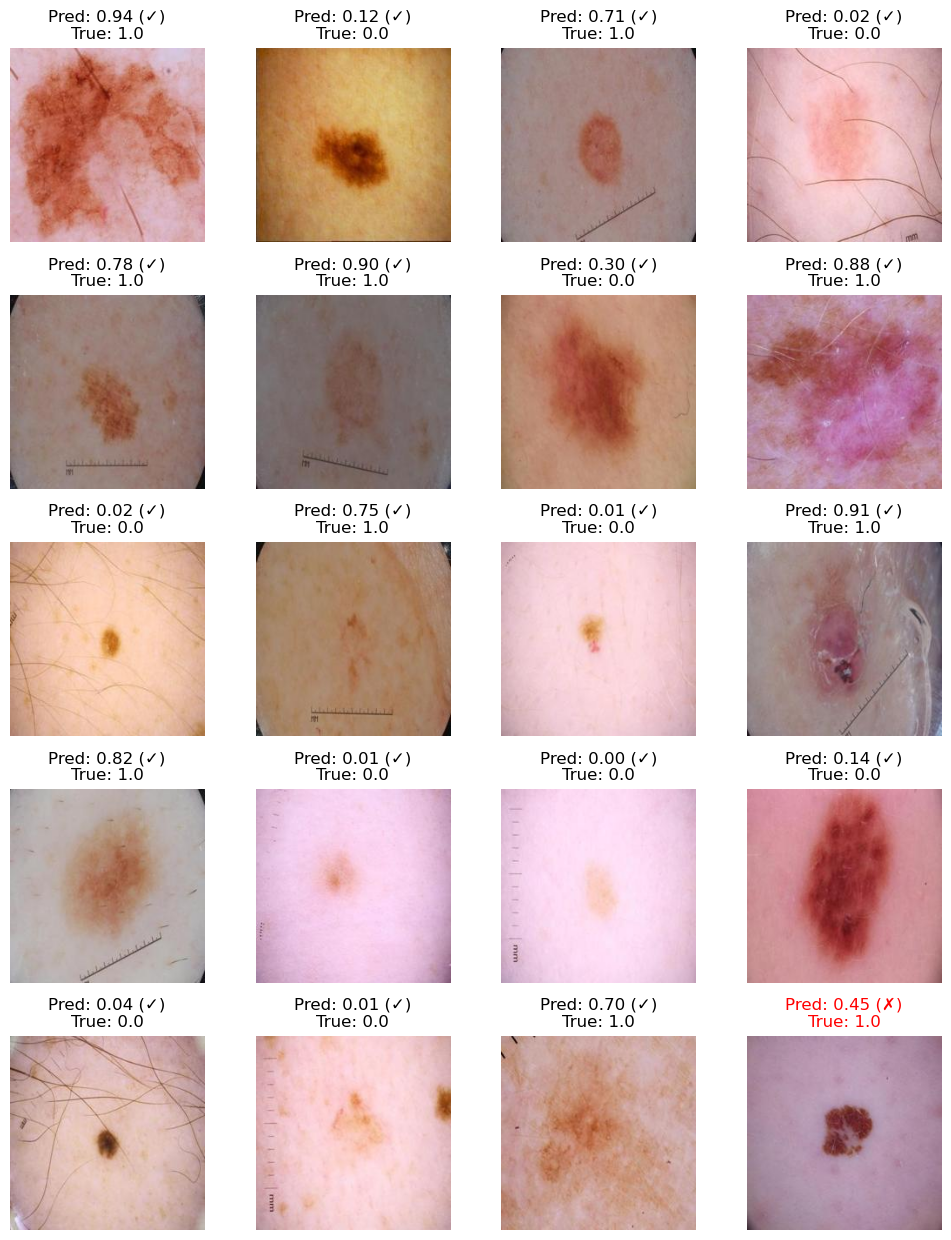

In [41]:
import matplotlib.pyplot as plt

# Define number of images, rows, and columns
num_images = 20
num_rows = 5
num_cols = 4

# Set the figure size
plt.figure(figsize=(2.5 * num_cols, 2.5 * num_rows))

# Loop through the first 20 images
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[i]) 

    true_label = y_test[i]
    pred_label = y_pred_cnn[i]
    probability = y_proba_cnn[i].item()  # Convert numpy array/scalar to a Python float

    # Check if prediction is correct
    title_color = 'red' if pred_label != true_label else 'black'
    title_text = f'Pred: {probability:.2f} ({"✓" if pred_label == true_label else "✗"})\nTrue: {true_label}'

    plt.title(title_text, color=title_color)
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


Confusion Matrix:
 [[879 121]
 [ 97 903]]
Precision: 0.8818
Recall: 0.9030
F1 Score: 0.8923


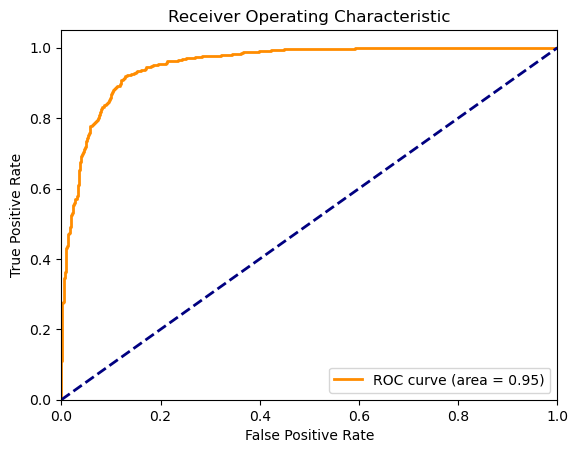

In [42]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc

def evaluate_model(y_true, y_pred, y_proba):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(y_test, y_pred_cnn, y_proba_cnn)

## Baseline MLP Classifier

In [ ]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Define the simple model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flat.shape[1],)), 
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_mlp_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model with the checkpoint
history = model.fit(
    X_train_flat, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,  # Using 20% of the data for validation
    callbacks=[checkpoint],  # Include the checkpoint in the callbacks
    verbose=1
)


In [44]:
# Load the best model
path = '/work/MLDL_Exam/Project/best_mlp_model.keras'
best_mlp_model = load_model(path)

X_test_flat = X_test.reshape(X_test.shape[0], -1)
test_loss, test_accuracy = best_mlp_model.evaluate(X_test_flat, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
best_mlp_model.summary()

ValueError: File not found: filepath=/work/MLDL_Exam/Project/best_mlp_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
y_proba_mlp = best_mlp_model.predict(X_test_flat)
y_pred_mlp = (y_proba_mlp > 0.5).astype(int)

In [ ]:
evaluate_model(y_test, y_pred_mlp, y_proba_mlp)

In [ ]:
import matplotlib.pyplot as plt

def plot_misclassified_images(images, true_labels, predicted_labels, label_names, misclass_type, num_images=9):
    """
    Plot images that were misclassified.
    misclass_type can be "FP" (False Positives) or "FN" (False Negatives)
    """
    if misclass_type == "FP":
        incorrect = (true_labels == 0) & (predicted_labels == 1)
        title = "False Positives"
    else:
        incorrect = (true_labels == 1) & (predicted_labels == 0)
        title = "False Negatives"

    # Filter images and labels
    misclassified_images = images[incorrect]
    misclassified_true_labels = true_labels[incorrect]
    misclassified_pred_labels = predicted_labels[incorrect]

    # Calculate number of rows and columns
    cols = 3
    rows = num_images // cols + (num_images % cols > 0)

    # Plot
    plt.figure(figsize=(cols * 4, rows * 4))  # Adjust size here as necessary
    for i, image in enumerate(misclassified_images[:num_images]):  # Control the number of images displayed
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        true_label_index = int(misclassified_true_labels[i])
        pred_label_index = int(misclassified_pred_labels[i])
        plt.title(f'True: {label_names[true_label_index]}\nPred: {label_names[pred_label_index]}')
        plt.axis('off')
    plt.tight_layout(pad = 3.0)  # Adjust layout to prevent overlap
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.show()

plot_misclassified_images(X_test, y_test, y_pred_cnn, ["Benign", "Malignant"], "FP", num_images=9)


In [ ]:
plot_misclassified_images(X_test, y_test, y_pred_cnn, ["Benign", "Malignant"], "FN", num_images=9)